<a href="https://colab.research.google.com/github/hemanths03/CS6910/blob/main/Assignment_1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
#!pip install wandb

In [3]:
import wandb
!wandb login

wandb: You can find your API key in your browser here: https://wandb.ai/authorize
wandb: Paste an API key from your profile and hit enter, or press ctrl+c to quit: 
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


In [4]:
import matplotlib.pyplot as plt
import matplotlib.colors
import numpy as np
from sklearn.metrics import accuracy_score, mean_squared_error
from sklearn.metrics import log_loss
from keras.datasets import fashion_mnist

In [5]:
(train_images, train_labels), (test_images, test_labels) = fashion_mnist.load_data()
labels = ["T-shirt/Top", "Trouser", "Pullover", "Dress", "Coat", "Sandal", "Shirt", "Sneaker", "Bag", "Ankle Boot"]
N , a , b = train_images.shape
#Dimesion of each Datapoint will be a*b
x = a*b
d=x
nl = len(labels)

4431872/4422102 [==============================] - 0s 0us/step


In [6]:
def show_images(train_images , train_labels , desc):
  m=0
  n=0
  k=0
  fig, axes = plt.subplots(2, 5, figsize=(12.5,6))
  for i in range(1000):
    if train_labels[i]==k:
      ax = axes[m,n]
      ax.imshow(train_images[i], cmap='gray')
      ax.set_title('Class='+str(train_labels[i])+', Label='+str(desc[train_labels[i]]))
      n=n+1
      k=k+1
      if(n==5):
        m=1
        n=0
    if k==10:
      break
  plt.tight_layout()
  plt.show()

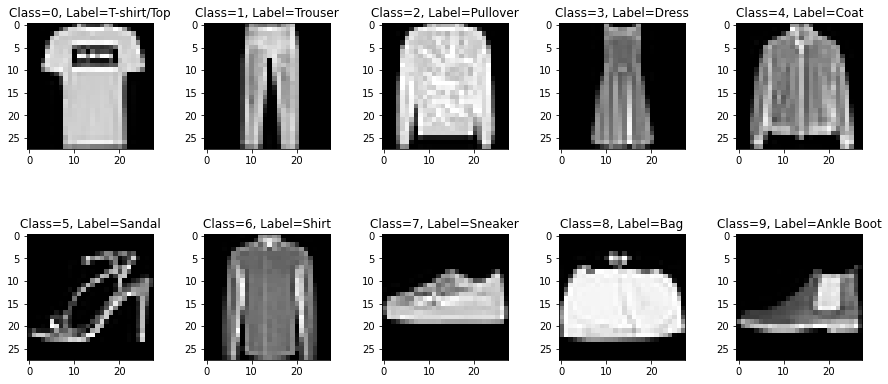

In [7]:
#Showing one image of each class (Question - 1)
show_images(train_images , train_labels,labels)

In [8]:
#Flattening we are converting the 28*28 data point as 784*1 data point
flatted_train_images =  np.array([train_images[i].flatten() for i in range(len(train_images))])
#Same transition for testdata
flatted_test_images =  np.array([test_images[i].flatten() for i in range(len(test_images))])

In [9]:
#getting train data and validation data from training data
from sklearn.model_selection import train_test_split
train_x, valid_x, cat_train_y, cat_val_y = train_test_split(flatted_train_images, train_labels, test_size=0.1, stratify = train_labels ,random_state=42)

In [10]:
#One hot encoding of categorical labels 
def encode(data , nl):
  encode_data = np.array( [ [0]*nl for i in range(len(data))] )
  for i in range(len(data)):
    actual_label = data[i]
    encode_data[i][actual_label] = 1
  return encode_data

In [11]:
train_y = encode(cat_train_y , nl)
valid_y = encode(cat_val_y , nl)
test_y = encode(test_labels , nl)

In [12]:
#Normalizing the data
mean = np.mean(train_x , axis = 0)
train_x = (train_x - mean) /255
valid_x = (valid_x - mean)/255
test_x = (flatted_test_images - mean)/255

In [13]:
print(train_x.shape)
print(valid_x.shape)
print(test_x.shape)
print(train_y.shape)
print(valid_y.shape)
print(test_y.shape)

(54000, 784)
(6000, 784)
(10000, 784)
(54000, 10)
(6000, 10)
(10000, 10)


In [14]:
def sigmoid(x):
    res = []
    for ele in x:
      res.append( 1 / ( 1 + np.exp(-(float(ele))) ) )
    return np.array(res)

def tanh(x):
    return np.array([ np.tanh(ele) for ele in x ] )

def relu(x):
    return np.array( [max(0, ele) for ele in x] )

def softmax(x):
  res = []
  denom = sum([ np.exp(float(ele)) for ele in x ])
  for ele in x:
    num = np.exp(float(ele))
    res.append(num / denom)
  return np.array(res)

def derivative_sigmoid(x):
  return x * (1 - x)

def derivative_tanh(x):
  return 1 - np.square(x)

def derivative_relu(x):
  return np.array([1 if x[i]>0 else 0 for i in range(len(x))])

In [15]:
def initialize_network(dim, hl, ol, method):
  W = [np.array([])]
  b = [np.array([])]
  np.random.seed(2)
  #Random intialization
  if(method=='random'):
    for i,nn in enumerate(hl):
      b.append(np.random.randn(nn))
      if(i == 0):
        W.append(np.random.randn(nn,dim))
      else:
        W.append(np.random.randn(nn,hl[i - 1]))
    for nn in ol:
      b.append(np.random.randn(nn))
      W.append(np.random.randn(nn,hl[-1]))
      
  #Xavier Initialization
  else:
    for i,nn in enumerate(hl):
      b.append(np.random.randn(nn))
      if(i == 0):
        W.append(np.random.randn(nn,dim ) * np.sqrt(1/dim))
      else:
        W.append(np.random.randn(nn,hl[i-1]) * np.sqrt(1/hl[i-1]))
    for nn in ol:
      b.append(np.random.randn(nn))
      W.append(np.random.randn(nn,hl[-1]) * np.sqrt(1/hl[-1]))

  return W,b

In [16]:
def forward_propagation(W,b,x,method):
    a = [[]]
    h = [[]]
    h[0] = x 
    num_layers = (len(W)-1)
    c = []
    d = []
    if method=='sigmoid':
        for i in range(1 , num_layers):
            c = np.dot( W[i], h[i-1] ) + b[i]
            a.append(c)
            d = sigmoid(c)
            h.append(d)

    elif method=='tanh':
        for i in range(1 , num_layers):
            c = np.dot( W[i], h[i-1] ) + b[i]
            a.append(c)
            d = tanh(c)
            h.append(d)

    elif method=='relu':
        for i in range(1 , num_layers):
            c = np.dot( W[i], h[i-1] ) + b[i]
            a.append(c)
            d = relu(c)
            h.append(d)

    c = np.dot( W[num_layers], h[num_layers-1] ) + b[num_layers]
    a.append(c)
    d = softmax(c)
    h.append(d)

    return a,h

In [ ]:
h[5].shape

(10,)

In [17]:
def back_prop(W,h,x,y,y_pred,act_fun,loss_fun):
  del_W,del_b=[[]],[[]]

  #computing output gradient
  if loss_fun == "cross_entropy" :
    del_a = (y_pred - y)
  else:
    y_label = y_pred[np.argmax(y)]
    del_a = 2 * (y_label - 1) * y_label * ( y - y_pred )

  for i in range(len(W)-1, 0, -1):

    #computing gradients wrt parameters W,b
    dW = np.outer( del_a, h[i-1] )
    db = np.array( del_a )

    #computing gradients wrt below layer activation function
    dh = np.dot( np.transpose(W[i]), del_a )

    #computing gradients wrt below layer pre-activation function
    if act_fun == "sigmoid":
      del_a = dh * derivative_sigmoid( h[i - 1] )
    
    elif act_fun == "tanh":
      del_a = dh * derivative_tanh( h[i - 1] )
    
    elif act_fun == "relu":
      del_a = dh * derivative_relu( h[i - 1] )

    del_W.insert(1, dW)
    del_b.insert(1, db)

  return del_W, del_b

In [18]:
def stochastic_gradient_descent(train_x,train_y,valid_x,valid_y,d,hl,ol,act_fun,loss_fun,epochs,eta,strat,alpha):
  W,b=initialize_network(d, hl, ol, strat)
  for e in range(epochs):
    dw,db=[],[]
    
    for it, (x, y) in enumerate(zip(train_x, train_y)):

      a,h = forward_propagation(W, b, x, act_fun)
      y_pred=h[len(h)-1]
      dw,db=back_prop(W, h, x, y, y_pred, act_fun, loss_fun)
      
      for i, (weight, deriv) in enumerate(zip(W, dw)):
        W[i] = weight - eta * np.array(deriv)

      for i, (bias, deriv) in enumerate(zip(b, db)):
        b[i] = bias - eta * np.array(deriv)

    val_acc, val_loss = get_predictions_accuracy(W, b, valid_x, valid_y, act_fun, loss_fun)
    train_acc, train_loss = get_predictions_accuracy(W, b, train_x, train_y, act_fun, loss_fun)
    test_acc, test_loss = get_predictions_accuracy(W, b, test_x, test_y, act_fun, loss_fun)
    print(e+1,"accuracy", train_acc , val_acc, test_acc)
    print(e+1,"loss",train_loss,val_loss,test_loss)
    '''wandb.log({
        "Epoch": e,
        "Train Loss": train_loss,
        "Train Acc": train_acc,
        "Valid Loss": val_loss,
        "Valid Acc": val_acc})
  return val_acc'''

In [43]:
def momentum_gradient_descent(train_x,train_y,valid_x,valid_y,d,hl,ol,act_fun,loss_fun,epochs,eta,strat,alpha):
  W,b=initialize_network(d, hl, ol, strat)
  dw , db = initialize_zeros(784,hl,ol)
  prev_w , prev_b = initialize_zeros(784,hl,ol)
  gamma=0.9
  batch=16
  seen=0
  for e in range(epochs):
    #dw , db = initialize_zeros(784,hl,ol)
    for it, (x, y) in enumerate(zip(train_x, train_y)):
      seen+=1
      a,h = forward_propagation(W, b, x, act_fun)
      y_pred=h[len(h)-1]
      
      tdw,tdb=back_prop(W, h, x, y, y_pred, act_fun, loss_fun)
  
      for i in range(len(tdw)):
        dw[i] += tdw[i]
        db[i] += tdb[i]
    
      if(seen==batch or it==len(train_x)-1):
        seen=0
        for i, (weight, deriv) in enumerate(zip(W, dw)):
          W[i] = weight - eta * np.array(deriv) - gamma*prev_w[i]
          prev_w[i] = eta * np.array(deriv) - gamma*prev_w[i]

        for i, (bias, deriv) in enumerate(zip(b, db)):
          b[i] = bias - eta * np.array(deriv) - gamma*prev_b[i]
          prev_b[i] = eta * np.array(deriv) - gamma*prev_b[i]

        dw , db = initialize_zeros(784,hl,ol)

    val_acc, val_loss = get_predictions_accuracy(W, b, valid_x, valid_y, act_fun, loss_fun)
    train_acc, train_loss = get_predictions_accuracy(W, b, train_x, train_y, act_fun, loss_fun)
    test_acc, test_loss = get_predictions_accuracy(W, b, test_x, test_y, act_fun, loss_fun)
    print(e+1,"accuracy", train_acc , val_acc, test_acc)
    #print(e+1,"loss",train_loss,val_loss,test_loss)
    '''wandb.log({
        "Epoch": e,
        "Train Loss": train_loss,
        "Train Acc": train_acc,
        "Valid Loss": val_loss,
        "Valid Acc": val_acc})
  return val_acc'''

In [20]:
def initialize_zeros(dim,hl,ol):
  _W = [np.array([])]
  _b = [np.array([])]
  for i,nn in enumerate(hl):
    _b.append(np.zeros(nn))
    if(i == 0):
      _W.append(np.zeros((nn,d)))
    else:
      _W.append(np.zeros((nn,hl[i - 1])))

  for nn in ol:
    _b.append(np.zeros(nn))
    _W.append(np.zeros((nn,hl[-1])))
  return _W , _b

In [31]:
def nesterov_gradient_descent(train_x,train_y,valid_x,valid_y,d,hl,ol,act_fun,loss_fun,epochs,eta,strat,alpha):
  W,b=initialize_network(d, hl, ol, strat)

  gamma=0.9
  seen=0
  batch=1
  
  prev_w , prev_b = initialize_zeros(784,hl,ol)
  v_w , v_b =initialize_zeros(784,hl,ol)
  prev_w , prev_b = initialize_zeros(784,hl,ol)
  dw , db = initialize_zeros(784,hl,ol)
  tw , tb = initialize_zeros(784,hl,ol)

  for e in range(epochs):
    
    for i in range(len(W)):
      v_w[i]=gamma*prev_w[i]
      v_b[i]=gamma*prev_b[i]

    for i in range(len(W)):
      tw[i] = W[i] - v_w[i]
      tb[i] = b[i] - v_b[i]
  
    for it, (x, y) in enumerate(zip(train_x, train_y)):
      seen+=1
      a,h = forward_propagation(tw, tb, x, act_fun)
      y_pred=h[len(h)-1]
      
      tdw,tdb=back_prop(tw, h, x, y, y_pred, act_fun, loss_fun)
      
      for i in range(len(tdw)):
        dw[i] += tdw[i]
        db[i] += tdb[i]

      if seen==batch or it == len(train_x)-1:
        seen=0
        for i, (weight, deriv) in enumerate(zip(W, dw)):
          v_w[i] = gamma*prev_w[i] + eta*np.array(deriv)
          W[i] = weight - v_w[i]
          tw[i] = W[i]
          prev_w = v_w

        for i, (bias, deriv) in enumerate(zip(b, db)):
          v_b[i] = gamma*prev_b[i] + eta*np.array(deriv)
          b[i] = bias - v_b[i]
          tb[i] = b[i]
          prev_b = v_b
        
        dw , db = initialize_zeros(784,hl,ol)

    val_acc, val_loss = get_predictions_accuracy(W, b, valid_x, valid_y, act_fun, loss_fun)
    train_acc, train_loss = get_predictions_accuracy(W, b, train_x, train_y, act_fun, loss_fun)
    test_acc, test_loss = get_predictions_accuracy(W, b, test_x, test_y, act_fun, loss_fun)
    print(e+1,"accuracy", train_acc , val_acc, test_acc)
    #print(e+1,"loss",train_loss,val_loss,test_loss)
    '''wandb.log({
        "Epoch": e,
        "Train Loss": train_loss,
        "Train Acc": train_acc,
        "Valid Loss": val_loss,
        "Valid Acc": val_acc})
  return val_acc'''

In [34]:
def get_predictions_accuracy(W, b, X, y, method, loss_fun):
  sum,loss=0,0
  for dp in range(len(X)):
    a = []
    h = []
    h = X[dp] 
    num_layers = (len(W)-1)
    if method=='sigmoid':
      for i in range(1 , num_layers):
        a = np.dot( W[i], h ) + b[i]
        h = sigmoid(a)

    elif method=='tanh':
      for i in range(1 , num_layers):
        a = np.dot( W[i], h ) + b[i]
        h = tanh(a)

    elif method=='relu':
      for i in range(1 , num_layers):
        a = np.dot( W[i], h ) + b[i]
        h = relu(a)

    a = np.dot( W[num_layers], h ) + b[num_layers]
    y_pred = softmax(a)

    ytrue = y[dp]
    if(ytrue[np.argmax(y_pred)]==1):
      sum=sum+1
    
    loss += -np.sum(ytrue*np.log(y_pred))

  acc=sum/len(X)
  loss=loss/len(X)
  return acc,loss


In [46]:
hidden_layer_size = 64
hidden_layers = 4
hl = [hidden_layer_size]*hidden_layers
ol = [len(train_y[0])]
n_hl = len(hl)
act_fun ='sigmoid'
loss_fun='cross-entropy'
eta=0.01
alpha=0
strat='random'
epochs=20
nesterov_gradient_descent(train_x,train_y,valid_x,valid_y,d,hl,ol,act_fun,loss_fun,epochs,eta,strat,alpha)

1 accuracy 0.7985185185185185 0.8046666666666666 0.7847
2 accuracy 0.832925925925926 0.834 0.8153
3 accuracy 0.8412037037037037 0.8378333333333333 0.8243
4 accuracy 0.8537407407407407 0.846 0.8342
5 accuracy 0.863462962962963 0.8558333333333333 0.8389
6 accuracy 0.8566666666666667 0.8451666666666666 0.8308
7 accuracy 0.8726296296296296 0.8571666666666666 0.845
8 accuracy 0.8790185185185185 0.8618333333333333 0.8478
9 accuracy 0.8747592592592592 0.8578333333333333 0.842
10 accuracy 0.8851851851851852 0.8655 0.8481
11 accuracy 0.8759629629629629 0.8588333333333333 0.8421
12 accuracy 0.8941296296296296 0.8728333333333333 0.8576
13 accuracy 0.8931296296296296 0.8695 0.8562
14 accuracy 0.8956481481481482 0.8728333333333333 0.8565
15 accuracy 0.893425925925926 0.8711666666666666 0.85
16 accuracy 0.8992592592592593 0.875 0.8572
17 accuracy 0.897074074074074 0.8748333333333334 0.8562
18 accuracy 0.8980925925925926 0.8738333333333334 0.8542
19 accuracy 0.8981481481481481 0.866 0.8523
20 accurac

In [ ]:
len(train_y)

54000

In [ ]:
def train():
  run=wandb.init()
  config = wandb.config
  loss_fun='cross-entropy'
  hl = [config.hidden_layer_size]*config.hidden_layers
  ol = [len(train_y[0])]

  name = "hl_" + str(config.hidden_layers) + "_size_" + str(config.hidden_layer_size) + "_ac_" + config.act_fun
  run.name = name

  alpha=0
  if config.optimizer == 'sgd':
    val_acc=stochastic_gradient_descent(train_x,train_y,valid_x,valid_y,d,hl,ol,config.act_fun,loss_fun,config.epochs,config.eta,config.strat,alpha)

In [ ]:
sweep_config_temp={
  "name": "asg 1",
  "method": "grid",
  'metric': {
      'name': 'Valid Acc',
      'goal': 'maximize'   
    },
  "parameters": {
        "epochs": {
            "values": [5,10]
        },
        "eta":{
            "values":[0.1,0.001]
        },
        "hidden_layers":{
            "values":[3,4,5]
        },
        "hidden_layer_size":{
            "values":[32,64,128]  
        },
        "optimizer":{
            "values":['sgd']
        },
        "batch_size":{
            "values":[16]
        },
        "alpha":{
            "values":[0,0.0005]
        },
        "act_fun":{
            "values":['tanh','relu','sigmoid']
        },
        "strat":{
            "values":['random','xavier']
        },
    }
}

In [ ]:
sweep_id = wandb.sweep(sweep_config_temp, entity="cs21m027_cs21m011", project="DL ASG")

Create sweep with ID: oys8dgli
Sweep URL: https://wandb.ai/cs21m027_cs21m011/DL%20ASG/sweeps/oys8dgli


In [ ]:
wandb.agent(sweep_id, train)

wandb: Agent Starting Run: gc7ys0ht with config:
wandb: 	act_fun: tanh
wandb: 	alpha: 0
wandb: 	batch_size: 16
wandb: 	epochs: 5
wandb: 	eta: 0.1
wandb: 	hidden_layer_size: 32
wandb: 	hidden_layers: 3
wandb: 	optimizer: sgd
wandb: 	strat: random


1 0.6834814814814815 0.6826666666666666 0.6732
2 0.7087037037037037 0.7101666666666666 0.6977
3 0.7126481481481481 0.7161666666666666 0.6997
4 0.7174259259259259 0.7256666666666667 0.7161
5 0.7466481481481482 0.7466666666666667 0.7438


Epoch,▁▃▅▆█
Train Acc,▁▄▄▅█
Train Loss,█▄▂▁▃
Valid Acc,▁▄▅▆█
Valid Loss,█▄▃▁▂
Epoch,4
Train Acc,0.74665
Train Loss,1.64527
Valid Acc,0.74667
Valid Loss,1.58785


wandb: Agent Starting Run: r5eazzqk with config:
wandb: 	act_fun: tanh
wandb: 	alpha: 0
wandb: 	batch_size: 16
wandb: 	epochs: 5
wandb: 	eta: 0.1
wandb: 	hidden_layer_size: 32
wandb: 	hidden_layers: 3
wandb: 	optimizer: sgd
wandb: 	strat: xavier


1 0.8152777777777778 0.8193333333333334 0.8049
2 0.8130740740740741 0.8186666666666667 0.8025
3 0.8251481481481482 0.8196666666666667 0.8102
4 0.8128888888888889 0.8141666666666667 0.7958
5 0.8073333333333333 0.8038333333333333 0.7861


Epoch,▁▃▅▆█
Train Acc,▄▃█▃▁
Train Loss,▁▃▅▆█
Valid Acc,███▆▁
Valid Loss,▁▂▆▆█
Epoch,4
Train Acc,0.80733
Train Loss,0.97645
Valid Acc,0.80383
Valid Loss,0.96451


wandb: Agent Starting Run: rara3hl8 with config:
wandb: 	act_fun: tanh
wandb: 	alpha: 0
wandb: 	batch_size: 16
wandb: 	epochs: 5
wandb: 	eta: 0.1
wandb: 	hidden_layer_size: 32
wandb: 	hidden_layers: 4
wandb: 	optimizer: sgd
wandb: 	strat: random


1 0.6464074074074074 0.6473333333333333 0.6468
2 0.6092592592592593 0.608 0.6043
3 0.5658888888888889 0.5731666666666667 0.5571
4 0.6286666666666667 0.6286666666666667 0.6255
5 0.6389259259259259 0.6401666666666667 0.6265


Epoch,▁▃▅▆█
Train Acc,█▅▁▆▇
Train Loss,▆█▄▂▁
Valid Acc,█▄▁▆▇
Valid Loss,▆█▄▂▁
Epoch,4
Train Acc,0.63893
Train Loss,2.04113
Valid Acc,0.64017
Valid Loss,2.03339


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: 5d3be96d with config:
wandb: 	act_fun: tanh
wandb: 	alpha: 0
wandb: 	batch_size: 16
wandb: 	epochs: 5
wandb: 	eta: 0.1
wandb: 	hidden_layer_size: 32
wandb: 	hidden_layers: 4
wandb: 	optimizer: sgd
wandb: 	strat: xavier


1 0.8018518518518518 0.8003333333333333 0.7936
2 0.8008518518518518 0.7975 0.789
3 0.7831851851851852 0.7873333333333333 0.7729
4 0.7629259259259259 0.7628333333333334 0.747
5 0.7428148148148148 0.7486666666666667 0.7326


Epoch,▁▃▅▆█
Train Acc,██▆▃▁
Train Loss,▁▂▂▅█
Valid Acc,██▆▃▁
Valid Loss,▁▂▂▅█
Epoch,4
Train Acc,0.74281
Train Loss,1.16702
Valid Acc,0.74867
Valid Loss,1.15288


wandb: Agent Starting Run: l0mhzbl2 with config:
wandb: 	act_fun: tanh
wandb: 	alpha: 0
wandb: 	batch_size: 16
wandb: 	epochs: 5
wandb: 	eta: 0.1
wandb: 	hidden_layer_size: 32
wandb: 	hidden_layers: 5
wandb: 	optimizer: sgd
wandb: 	strat: random


1 0.4692222222222222 0.4731666666666667 0.467
2 0.5173518518518518 0.5186666666666667 0.5137
3 0.4827222222222222 0.4805 0.4733
4 0.5460185185185186 0.5458333333333333 0.5516
5 0.5236666666666666 0.5238333333333334 0.5206


Epoch,▁▃▅▆█
Train Acc,▁▅▂█▆
Train Loss,█▆▆▃▁
Valid Acc,▁▅▂█▆
Valid Loss,█▆▇▃▁
Epoch,4
Train Acc,0.52367
Train Loss,2.74643
Valid Acc,0.52383
Valid Loss,2.74399


wandb: Agent Starting Run: 9hw2oovw with config:
wandb: 	act_fun: tanh
wandb: 	alpha: 0
wandb: 	batch_size: 16
wandb: 	epochs: 5
wandb: 	eta: 0.1
wandb: 	hidden_layer_size: 32
wandb: 	hidden_layers: 5
wandb: 	optimizer: sgd
wandb: 	strat: xavier


1 0.7640740740740741 0.7665 0.7522
2 0.7595 0.765 0.7518
3 0.7405185185185185 0.7455 0.7265
4 0.732925925925926 0.7435 0.7286
5 0.7502777777777778 0.7555 0.7407


Epoch,▁▃▅▆█
Train Acc,█▇▃▁▅
Train Loss,▁▃▄█▆
Valid Acc,██▂▁▅
Valid Loss,▁▃▄█▅
Epoch,4
Train Acc,0.75028
Train Loss,1.19297
Valid Acc,0.7555
Valid Loss,1.16431


wandb: Agent Starting Run: t2bvurbx with config:
wandb: 	act_fun: tanh
wandb: 	alpha: 0
wandb: 	batch_size: 16
wandb: 	epochs: 5
wandb: 	eta: 0.1
wandb: 	hidden_layer_size: 64
wandb: 	hidden_layers: 3
wandb: 	optimizer: sgd
wandb: 	strat: random


1 0.6877037037037037 0.694 0.6789
2 0.695462962962963 0.7056666666666667 0.6839
3 0.6967962962962962 0.7011666666666667 0.6901
4 0.7017592592592593 0.7118333333333333 0.6966
5 0.7101666666666666 0.7166666666666667 0.7036


Epoch,▁▃▅▆█
Train Acc,▁▃▄▅█
Train Loss,█▇▆▅▁
Valid Acc,▁▅▃▇█
Valid Loss,██▇▅▁
Epoch,4
Train Acc,0.71017
Train Loss,3.56822
Valid Acc,0.71667
Valid Loss,3.42124


wandb: Agent Starting Run: wbfrghwr with config:
wandb: 	act_fun: tanh
wandb: 	alpha: 0
wandb: 	batch_size: 16
wandb: 	epochs: 5
wandb: 	eta: 0.1
wandb: 	hidden_layer_size: 64
wandb: 	hidden_layers: 3
wandb: 	optimizer: sgd
wandb: 	strat: xavier


1 0.8029814814814815 0.8053333333333333 0.7943
2 0.7915925925925926 0.7921666666666667 0.7815
3 0.8006666666666666 0.8075 0.7923
4 0.7973518518518519 0.7971666666666667 0.7884
5 0.8032777777777778 0.8091666666666667 0.7976


Epoch,▁▃▅▆█
Train Acc,█▁▆▄█
Train Loss,▁▅█▇▇
Valid Acc,▆▁▇▃█
Valid Loss,▁▅█▇▇
Epoch,4
Train Acc,0.80328
Train Loss,1.93544
Valid Acc,0.80917
Valid Loss,1.89217


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: jxztamb3 with config:
wandb: 	act_fun: tanh
wandb: 	alpha: 0
wandb: 	batch_size: 16
wandb: 	epochs: 5
wandb: 	eta: 0.1
wandb: 	hidden_layer_size: 64
wandb: 	hidden_layers: 4
wandb: 	optimizer: sgd
wandb: 	strat: random


1 0.6134074074074074 0.6145 0.6136
2 0.6061481481481481 0.607 0.5998
3 0.6146111111111111 0.6225 0.6128
4 0.6201296296296296 0.6218333333333333 0.6191
5 0.6286111111111111 0.636 0.6227


Epoch,▁▃▅▆█
Train Acc,▃▁▄▅█
Train Loss,▂▂▁▆█
Valid Acc,▃▁▅▅█
Valid Loss,▂▃▁▆█
Epoch,4
Train Acc,0.62861
Train Loss,5.28197
Valid Acc,0.636
Valid Loss,5.07735


wandb: Agent Starting Run: yuqkveho with config:
wandb: 	act_fun: tanh
wandb: 	alpha: 0
wandb: 	batch_size: 16
wandb: 	epochs: 5
wandb: 	eta: 0.1
wandb: 	hidden_layer_size: 64
wandb: 	hidden_layers: 4
wandb: 	optimizer: sgd
wandb: 	strat: xavier


1 0.7561296296296296 0.76 0.7447
2 0.7782592592592592 0.7803333333333333 0.7695
3 0.7645555555555555 0.765 0.7548
4 0.7787222222222222 0.7863333333333333 0.7646
5 0.7350925925925926 0.7388333333333333 0.7325


Epoch,▁▃▅▆█
Train Acc,▄█▆█▁
Train Loss,▁▂▄▅█
Valid Acc,▄▇▅█▁
Valid Loss,▁▂▅▅█
Epoch,4
Train Acc,0.73509
Train Loss,2.85009
Valid Acc,0.73883
Valid Loss,2.7575


wandb: Agent Starting Run: an5cegp5 with config:
wandb: 	act_fun: tanh
wandb: 	alpha: 0
wandb: 	batch_size: 16
wandb: 	epochs: 5
wandb: 	eta: 0.1
wandb: 	hidden_layer_size: 64
wandb: 	hidden_layers: 5
wandb: 	optimizer: sgd
wandb: 	strat: random


1 0.4754074074074074 0.47783333333333333 0.4736
2 0.4815185185185185 0.4726666666666667 0.4794
3 0.5168888888888888 0.5211666666666667 0.5105
4 0.4595 0.461 0.4605
5 0.48483333333333334 0.4816666666666667 0.4826


Epoch,▁▃▅▆█
Train Acc,▃▄█▁▄
Train Loss,▁▅██▇
Valid Acc,▃▂█▁▃
Valid Loss,▁▅█▇▇
Epoch,4
Train Acc,0.48483
Train Loss,9.42986
Valid Acc,0.48167
Valid Loss,9.57486


wandb: Agent Starting Run: 2uomp4xi with config:
wandb: 	act_fun: tanh
wandb: 	alpha: 0
wandb: 	batch_size: 16
wandb: 	epochs: 5
wandb: 	eta: 0.1
wandb: 	hidden_layer_size: 64
wandb: 	hidden_layers: 5
wandb: 	optimizer: sgd
wandb: 	strat: xavier


1 0.7531666666666667 0.7615 0.7502
2 0.7778148148148148 0.7765 0.7706
3 0.7435185185185185 0.7508333333333334 0.7378
4 0.7470925925925926 0.7465 0.7373
5 0.7077407407407408 0.7015 0.7014


Epoch,▁▃▅▆█
Train Acc,▆█▅▅▁
Train Loss,▁▁▃▄█
Valid Acc,▇█▆▅▁
Valid Loss,▁▁▃▄█
Epoch,4
Train Acc,0.70774
Train Loss,2.85558
Valid Acc,0.7015
Valid Loss,2.79468


wandb: Agent Starting Run: ql4zt7p3 with config:
wandb: 	act_fun: tanh
wandb: 	alpha: 0
wandb: 	batch_size: 16
wandb: 	epochs: 5
wandb: 	eta: 0.1
wandb: 	hidden_layer_size: 128
wandb: 	hidden_layers: 3
wandb: 	optimizer: sgd
wandb: 	strat: random


1 0.6137592592592592 0.6171666666666666 0.6074
2 0.6561111111111111 0.658 0.6521
3 0.6672037037037037 0.6675 0.6647
4 0.6960555555555555 0.707 0.6923
5 0.6572407407407408 0.667 0.655


Epoch,▁▃▅▆█
Train Acc,▁▅▆█▅
Train Loss,▅▃▆▁█
Valid Acc,▁▄▅█▅
Valid Loss,▅▄▆▁█
Epoch,4
Train Acc,0.65724
Train Loss,7.55053
Valid Acc,0.667
Valid Loss,7.25989


wandb: Agent Starting Run: 1cedz7km with config:
wandb: 	act_fun: tanh
wandb: 	alpha: 0
wandb: 	batch_size: 16
wandb: 	epochs: 5
wandb: 	eta: 0.1
wandb: 	hidden_layer_size: 128
wandb: 	hidden_layers: 3
wandb: 	optimizer: sgd
wandb: 	strat: xavier


1 0.7629074074074074 0.771 0.752
2 0.7477407407407407 0.7463333333333333 0.7384
3 0.7963888888888889 0.7971666666666667 0.783
4 0.7733703703703704 0.7756666666666666 0.7637
5 0.7911666666666667 0.7906666666666666 0.777


Epoch,▁▃▅▆█
Train Acc,▃▁█▅▇
Train Loss,▁▄▃█▇
Valid Acc,▄▁█▅▇
Valid Loss,▁▄▃█▇
Epoch,4
Train Acc,0.79117
Train Loss,4.35777
Valid Acc,0.79067
Valid Loss,4.15658


wandb: Agent Starting Run: 56di21qb with config:
wandb: 	act_fun: tanh
wandb: 	alpha: 0
wandb: 	batch_size: 16
wandb: 	epochs: 5
wandb: 	eta: 0.1
wandb: 	hidden_layer_size: 128
wandb: 	hidden_layers: 4
wandb: 	optimizer: sgd
wandb: 	strat: random


1 0.4477037037037037 0.4435 0.4486


wandb: Ctrl + C detected. Stopping sweep.
